In [1]:
import time
start = time.time()
import cv2
import numpy as np
import matplotlib.pyplot as plt
# import sys
# import os
# import glob
print(time.time()-start,'s')

6.555119037628174 s


In [46]:
def order_points(pts,crop,main=0):
    ''' The function returns the 4 corner points in '''
    rect = np.zeros((4, 2), dtype = "float32")
 

    s = pts.sum(axis = 1)
#     print(s)
#     print(pts)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
 

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
#     if main:
#         rect[1][1]-=40
#         rect[1][1]=rect[0][1]
#         widthA = np.sqrt(((rect[2][0] - rect[3][0]) ** 2) + ((rect[2][1] - rect[3][1]) ** 2))
#         rect[1][0]=rect[0][0]+int(widthA)
#         print("Entered")
#         min_y = min(pts[:,1])
#         max_x = max(pts[:,0])
#         rect[1][0] = max_x
#         rect[1][1] = min_y
    
    #cropping a little more towards left
    rect[0][0] -=crop
    rect[3][0] -=crop
    #cropping a little more towards right
    rect[1][0] +=crop
    rect[2][0] +=crop
    #cropping a little more towards bottom
    rect[3][1] +=crop
    rect[2][1] +=crop
 
    return rect

In [35]:
def get_outer_points(pts,crop):

    rect = np.zeros((4, 2), dtype = "float32")
 
    min_x = min(pts[:,0])
    min_y = min(pts[:,1])
    max_x = max(pts[:,0])
    max_y = max(pts[:,1])
    #s = pts.sum(axis = 1)
    #print(s)
    rect[0][0] = min_x
    rect[0][1] = min_y
    rect[2][0] = max_x
    rect[2][1] = max_y
 

    #diff = np.diff(pts, axis = 1)
    #print(diff)
    rect[1][0] = max_x
    rect[1][1] = min_y
    rect[3][0] = min_x
    rect[3][1] = max_y
    
    #cropping a little more towards left
    rect[0][0] -=crop
    rect[3][0] -=crop
    #cropping a little more towards right
    rect[1][0] +=crop
    rect[2][0] +=crop
    #cropping a little more towards bottom
    rect[3][1] +=crop
    rect[2][1] +=crop
 
    return rect

In [36]:
def four_point_warp(image, pts,crop,outer=1,main=0):

    if outer:
        rect = get_outer_points(pts,crop)
    else :
        rect = order_points(pts,crop,main)
    (tl, tr, br, bl) = rect
    print(rect)

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
              [0, 0],
              [maxWidth - 1, 0],
              [maxWidth - 1, maxHeight - 1],
              [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    cv2.imwrite('Out.jpg',warped)
 
    return warped

In [ ]:
def compare_features_orb(gray_main, gray_crop, mask_x=None, mask_y=None):
    #Trying feature matching using ORB
    orb = cv2.ORB_create()
    Mask = None
    #cv2.rectangle(mask, (int(width/10),int(18*height/25)),(int(15*width/16),int(13*height/14)), (255), thickness = -1)
    #cv2.rectangle(mask,(int(width/10),int(2*height/17)),(int(13*width/21),int(4*height/29)),(255),-1)
    #cv2.rectangle(mask, (int(width/10),int(18*height/25)),(int(15*width/16),int(13*height/14)), (255), thickness = -1)
    if mask_x and mask_y:
        Mask = np.zeros(gray_main.shape[:2], dtype=np.uint8)
        cv2.rectangle(Mask, mask_x, mask_y, (255), thickness = -1)
    # find the keypoints and descriptors with SIFT
    kp1, des1 = orb.detectAndCompute(gray_main,mask)
    kp2, des2 = orb.detectAndCompute(gray_crop,None)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches = bf.match(des1,des2)

    matches = sorted(matches, key = lambda x:x.distance)

    img = cv2.drawMatches(gray_main,kp1,gray_crop,kp2,matches,None, flags=2)

    cv2.imwrite('Out1.jpg',img)
    return np.float32([ kp1[m.queryIdx].pt for m in matches ])

In [37]:
def compare_features(gray_main, gray_crop, mask_x=None, mask_y=None):
    #Trying feature matching using SIFT
    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    Mask=None
    #mask for residential address
    #cv2.rectangle(mask, (int(0),int(18*height/25)),(width,int(25*height/26)), (255), thickness = -1)
    
    if mask_x and mask_y:
        Mask = np.zeros(gray_main.shape[:2], dtype=np.uint8)
        cv2.rectangle(Mask, mask_x, mask_y, (255), thickness = -1)
    
    #mask for branch
    #cv2.rectangle(mask,(int(width/10),int(3*height/27)),(int(10*width/11),int(3*height/20)),(255),-1)
    
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(gray_main,Mask)
    kp2, des2 = sift.detectAndCompute(gray_crop,None)
    
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    matches = flann.knnMatch(des1,des2,k=2,mask=Mask)
    
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.8*n.distance:
            good.append(m)
    
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    
    h,w = gray_main.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    
    
    img2 = cv2.polylines(gray_crop,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

    img3 = cv2.drawMatches(gray_main,kp1,gray_crop,kp2,good,None,**draw_params)
    cv2.imwrite('Out1.jpg',img3)
    return np.float32([ kp1[m.queryIdx].pt for m in good ])

In [38]:
def read_input(main_file, crop_file):
    img1 = cv2.imread(main_file)
    crop = cv2.imread(crop_file)
    gray_main = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    gray_crop = cv2.cvtColor(crop,cv2.COLOR_BGR2GRAY)
    height_main, width_main = gray_main.shape
    height_crop, width_crop = gray_crop.shape
    height = height_main
    width = width_main
    print(height_main, width_main)
    print(height_crop, width_crop)
    return img1, gray_main, gray_crop, height, width
    #cv2.imwrite('Out.jpg',gray_main)

In [50]:
start_time = time.time()
img1, gray_main, gray_crop, height, width = read_input('form-samples/filled-s1.jpg', 'form-samples/unfilled_pa.jpg')
points = compare_features_orb(gray_main, gray_crop)


# For residential address
# address_x = (int(0),int(18*height/25))
# address_y = (width,int(25*height/26))

# points = compare_features(gray_main, gray_crop, address_x, address_y)
# points = points[points[:,1]>(7*height)/10]


3507 2481
3507 2481


In [51]:
crop = 30
dst = four_point_warp(gray_main, points, crop, outer=0,main=1)
print(time.time()-start_time)

[[  284.26904297   443.30407715]
 [ 2294.56762695   559.793396  ]
 [ 2274.90893555  3354.03710938]
 [  201.33454895  3341.71875   ]]
224.92750453948975


In [60]:
points = compare_features(dst, gray_crop, (0,0), dst.shape)
crop = 5
dest = four_point_warp(dst, points,crop,0)

[[  42.65208054    2.55597544]
 [ 845.87817383   21.94199371]
 [ 833.54748535  740.86218262]
 [  41.58750153  779.41949463]]


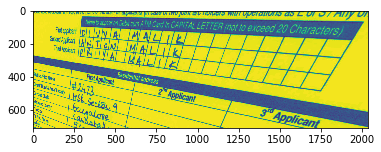

In [42]:
plt.imshow(dst)
plt.show()